<a href="https://colab.research.google.com/github/brenoskuk/ML_exercises/blob/master/person_classification_artworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Person classification in artworks Challenge

## Author: Breno BALDAS SKUK

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread # Install scikit-image if needed
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.applications import VGG19
from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


To save models:

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

First we download the data from my google drive

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BjGjNnFA5fiHrdz53PKrrCFU-aL-FoGo',
                                    dest_path='./data.zip',
                                    unzip=True)

data_path = './data'

In the data folder you can find 2 [CSV](https://fr.wikipedia.org/wiki/Comma-separated_values) files and a folder name im cointining 10000 images of artworks images (mostly paintings). The first CSV file is train.csv, it contains the name of the image with the class of each image. You can read it with [pandas](https://pandas.pydata.org/) as follow :

In [ ]:
df = pd.read_csv('data/train.csv')
X_df = df['name']
y_df = df['person']
X = X_df.values
y = y_df.values

# Getting Started:


### Useful functions to manipulate data

In [ ]:
# Given image name, returns image file
def get_img(name_im, path = 'data/im/{}.jpg'):
  filename = path.format(name_im)
  image = imread(filename)
  return image


# scale image to WxH format
def scale_WH(img, W,H):
  return resize(img,(W,H), mode='reflect')

# Create array of downsampled WxH images
def get_scaled_array(X, W, H, path = 'data/im/{}.jpg'):
  X_d = []
  print("Number of images to scale = ", len(X),"\n")
  for i in range(len(X)):
    img = get_img(X[i],path)
    # grayscale must convert to rgb
    #print(img.shape)
    if (len(img.shape) < 3):
      conv = (cv2.cvtColor(img,cv2.COLOR_GRAY2RGB))
      X_d.append(scale_WH(conv,W,H))
    else:
      X_d.append(scale_WH(img,W,H))
    if(i%1000 == 0):
      print(i, " scaled images out of ", len(X), "\n")
  print("Finished!")
  return np.array(X_d)

### Useful functions to work with models

We implement our own functions to evaluate a given model. Defining a threshold of 0.5 to detect or not a person on a painting, as sugested by the documentation of keras.

In [ ]:
def generate_prediction(X_test, model):
  tr = 0.5
  try: 
    n = X_test.shape[0]
  except:
    n = len(X_test)
  y_pred = np.zeros(n)
  
  for i in range(0,n):
    try:
      val = model.predict(np.expand_dims(X_test[i,:,:,:],axis=0))[0][0]
    except:
      val = model.predict(np.expand_dims(np.array(X_test[i]),axis=0))[0][0]
    if(val >= tr):
      y_pred[i] = int(1)
  return y_pred

def f1_prediction(y_pred,y):
  fp = []
  fn = []
  tn = []
  tp = []
  count = 0
  for i in range(y_pred.shape[0]):
    # false positive
    if (y_pred[i] == 1 and y_test[i] == 0):
      fp.append(i)
    # false negative
    if (y_pred[i] == 0 and y_test[i] == 1):
      fn.append(i)
    # correct class 0
    if (y_pred[i] == 0 and y_test[i] == 0):
      tn.append(i)
    # correct class 1
    if (y_pred[i] == 1 and y_test[i] == 1):
      tp.append(i)  
  if((len(tp)+len(fp)) != 0 and (len(tp)+len(fn)) != 0):
    precision = len(tp)/(len(tp)+len(fp))
    recall = len(tp)/(len(tp)+len(fn))
    f1 = 2*(precision*recall)/(precision+recall)
  else:
    print("Division by zero... change tr!")
    
  print("false positive = ", len(fp),"\nfalse negative = ", len(fn),
        "\ntrue negative = ", len(tn) ,"\ntrue positive = ", len(tp))

  print("precision = ", precision, "\nrecall = ", recall, "\nf1 = ", f1)
  return   fp , fn , tn , tp 
  



### Exploratory analisys

First, let's separate the paintings containing by labels.

In [ ]:
idx_ppl = []
idx_no_ppl = []
for i in range(len(y)):
  if y[i] == 1:
    idx_ppl.append(i)
  else:
    idx_no_ppl.append(i)
idx_ppl = np.array(idx_ppl)
idx_no_ppl = np.array(idx_no_ppl)
print("There are ", idx_ppl.shape[0], " images containing people")
print("There are ", idx_no_ppl.shape[0], " images containing no people")

There are  1449  images containing people
There are  3551  images containing no people


Let's see minimum and maximum dimenions of the dataset images

In [ ]:
# Get min, max and average dimension of images
min_h, min_w = 99999,99999
max_h, max_w = 0,0
th =0
tw =0
for i in range(len(X)):
  w,h,_ = get_img(X[i]).shape
  if w < min_w:
    min_w = w
  if h < min_h:
    min_h = h
  if w > max_w:
    max_w = w
  if h > max_h:
    max_h = h
  tw = tw + w
  th = th + h
print("min h =", min_h, "\nmin w = ", min_w)
print("max h =", max_h, "\nmax w = ", max_w)
print("average h =", th/len(X), "\naverage w = ", tw/len(X))


min h = 80 
min w =  82
max h = 500 
max w =  500
average h = 406.7482 
average w =  410.8062


As we can see, images aren't very big, and we have a notion of how resizing them to (224, 224) format would not affect them greatly.

In [ ]:
X_d = get_scaled_array(X, 224, 224)

Number of images to scale =  5000 

0  scaled images out of  5000 

1000  scaled images out of  5000 

2000  scaled images out of  5000 

3000  scaled images out of  5000 

4000  scaled images out of  5000 

Finished!


Let's see how images containing people look

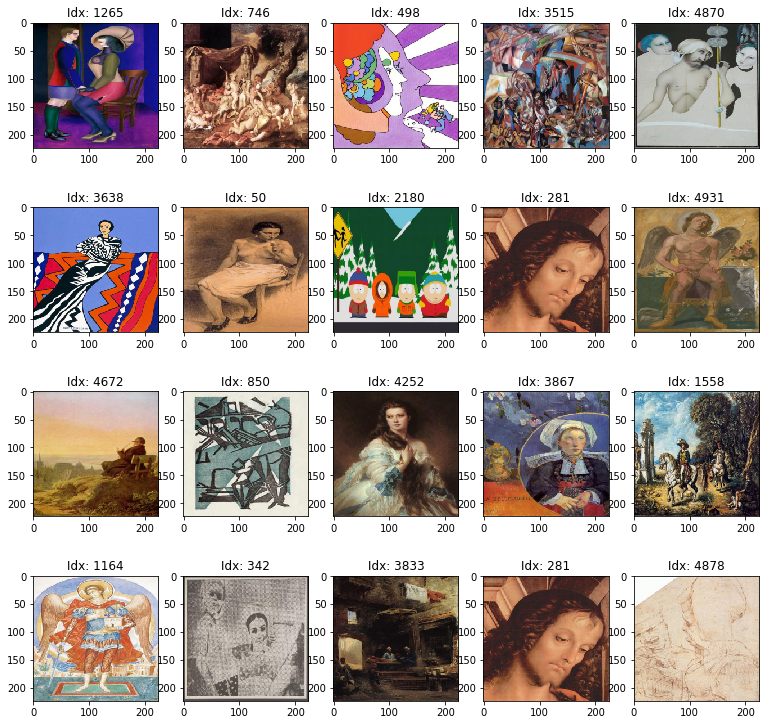

In [ ]:
# plot the 20 random images of the dataset with images containing people
plt.figure(figsize=(13, 13))
for idx in range(0,20):
    i = np.random.randint(0,idx_ppl.shape[0])
    plt.subplot(4, 5, idx+1)
    plt.imshow(X_d[idx_ppl[i],:,:],interpolation='nearest')
    title = 'Idx: ' + str(idx_ppl[i])
    plt.title(title)

Let's see how images that don't containing people look like

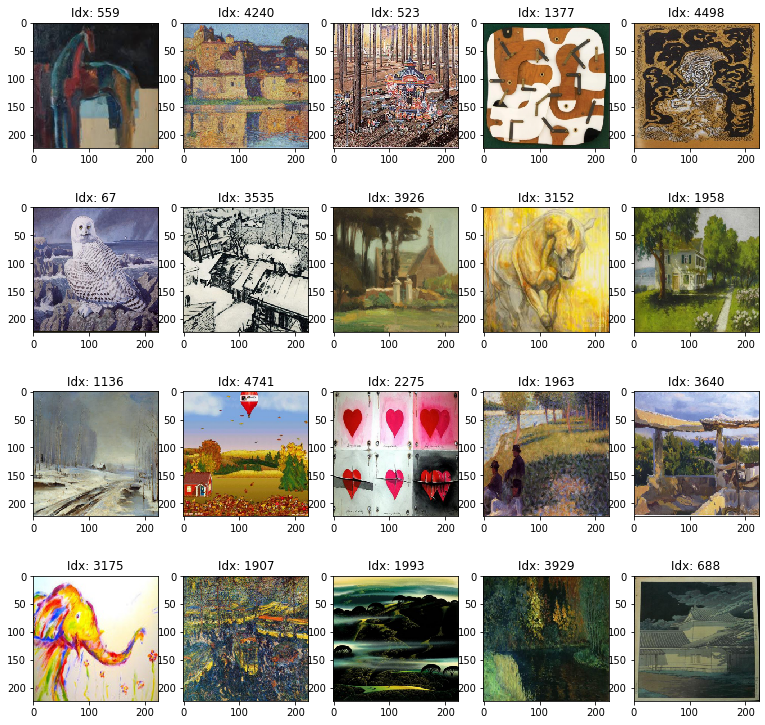

In [ ]:
# plot the 20 random images of the dataset with images without people
plt.figure(figsize=(13, 13))
for idx in range(0,20):
    i = np.random.randint(0,idx_no_ppl.shape[0])
    plt.subplot(4, 5, idx+1)
    plt.imshow(X_d[idx_no_ppl[i],:,:],interpolation='nearest')
    title = 'Idx: ' + str(idx_no_ppl[i])
    plt.title(title)

*Comment:* As we can see, there is great variation among paintings containing people. Images without people also present great variation, and at first sight don't have a set of interesting features besides the obvious lack of a human figure. However, some have animals and objects resemble people. This will be difficult to analyse, and will probably result in missclassification if not treated right.

### Separating data into Training and testing

In [ ]:
# Separating in training and testing set
training_sample = 4900
X_train = X_d[:training_sample,:,:]
y_train = y[:training_sample]
X_test = X_d[training_sample:,:,:]
y_test = y[training_sample:]

## Deep Neural Network

First, let's prepare data to be feed into the neural networks

In [ ]:
# input image dimensions
try:
  img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
except:
  img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1
# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


Y_train = y_train
Y_test = y_test
#Y_train = to_categorical(y_train)
#Y_test = to_categorical(y_test)

try:
  nb_classes = Y_train.shape[1]
except:
  nb_classes = 1
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (4900, 224, 224, 3)
Y_train shape: (4900,)
There is 4900 train data
There is 100 test data
224 224 3


A first approach using Deep Neural Networks is to use the VGG16 implementation with weights pre-trained on ImageNet dataset. Convolutional layers are fixend and we will only train the top layers on the data. This will be fast but probably not very accurate since the network wasn't created to work on paintings. 

Given we want only to detect one class, we use binary_crossentropy cross_function and a sigmoid. We are thus treating the problem as regression problem.

In [ ]:
keras.backend.clear_session()

NameError: ignored

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

58892288/58889256 [==============================] - 3s 0us/step


In [ ]:
learning_rate = 0.001
n_epochs = 15
batch_size = 100
# OBS: MUCH FASTER IF GPU IS USED
model.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6471 - acc: 0.6697 - val_loss: 0.5719 - val_acc: 0.7210
Epoch 2/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.5764 - acc: 0.7117 - val_loss: 0.5349 - val_acc: 0.7320
Epoch 3/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.5410 - acc: 0.7375 - val_loss: 0.5126 - val_acc: 0.7610
Epoch 4/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.5219 - acc: 0.7570 - val_loss: 0.4938 - val_acc: 0.7760
Epoch 5/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.5053 - acc: 0.7657 - val_loss: 0.4824 - val_acc: 0.7840
Epoch 6/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.4862 - acc: 0.7760 - val_loss: 0.4707 - val_acc: 0.7950
Epoch 7/10
4000/4000 [==============================] - 50s 12ms/step - loss: 0.4648 - acc: 0.7847 - val_loss: 0.4563 - val_acc: 0.7970


We can see that the model is not overfitting too much, but it's performance leaves a lot to desire... 

In [ ]:
y_pred = generate_prediction(X_test,model)
fp, fn, tn, tp = f1_prediction(y_pred,y_test)

false positive =  56 
false negative =  131 
true negative =  665 
true positive =  148
precision =  0.7254901960784313 
recall =  0.5304659498207885 
f1 =  0.6128364389233955


This isn't a very satisfactory result at all, but printing the false positives and false negatives may tell us what happened.

FALSE POSITIVES: 


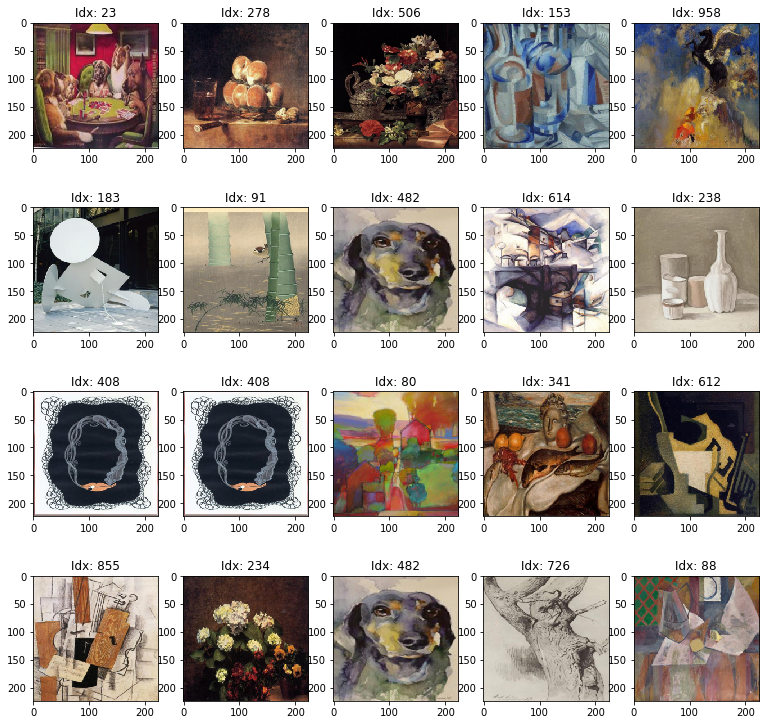

In [ ]:
print("FALSE POSITIVES: ")
plt.figure(figsize=(13, 13))
for idx in range(20):
    i = np.random.randint(0,len(fp))
    plt.subplot(4, 5, idx+1)
    plt.imshow(X_test[fp[i]],interpolation='nearest')
    title = 'Idx: ' + str(fp[i])
    plt.title(title)

FALSE NEGATIVES: 


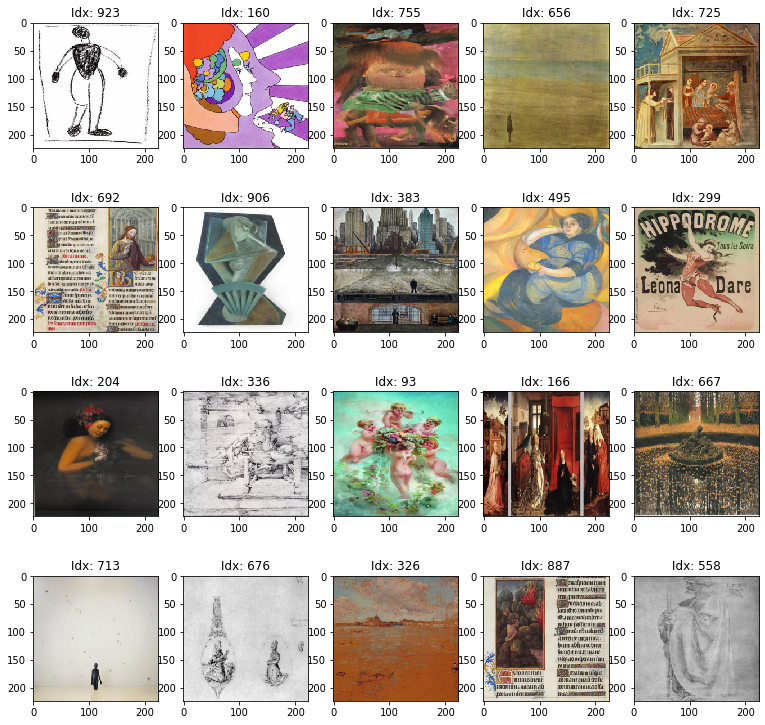

In [ ]:
print("FALSE NEGATIVES: ")
plt.figure(figsize=(13, 13))
for idx in range(20):
    i = np.random.randint(0,len(fn))
    plt.subplot(4, 5, idx+1)
    plt.imshow(X_test[fn[i]],interpolation='nearest')
    title = 'Idx: ' + str(fn[i])
    plt.title(title)

We can see that at first glance there are two main problems with our detector:

1. Faces and bodies in certaing positions or drawed in a different way seem to be left ignored by the algorithm, resulting in false negatives. 

2. Animals, specially their faces, seem to be recognized as a persons.



### Retraining other convolutional layers.

In the previous case, we trained only the last fully conected layers of VGG16. It may be interesting to allow other convolutional layer to be trained on features of this dataset, since the VGG16 was originally conceived to work over real images, the result might improve.

Three tests were made: 

1. Allowing only the first two layers to train.
2. Allowing only the last two layers to train.
3. Allowing all layers to train.

The best results were obtained allowing the all the layers to be trained, achieving an accuracy on the testing set of almost 90%. 

In [ ]:
keras.backend.clear_session()

In [ ]:
conv_base_2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base_2.trainable = True

Let's print the layer names

In [ ]:
for layer in conv_base_2.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


VGG16 was trained on photograps, not on paintings. Considering that the first convolutional layers of a CNN are responsible for it's initial treatment, let's turn on training for those and see what happens. 

In [ ]:
conv_base_2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base_2.trainable = True

# model will be trainable after training_label
training_label = 'block1_conv1'
set_trainable = False
for layer in conv_base_2.layers:
    if layer.name == training_label:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model_2 = models.Sequential()
model_2.add(conv_base_2)
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
learning_rate = 0.001
n_epochs = 6
batch_size = 50
# OBS: MUCH FASTER IF GPU IS USED
model_2.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4900 samples, validate on 100 samples
Epoch 1/6
4900/4900 [==============================] - 145s 30ms/step - loss: 0.5837 - acc: 0.7145 - val_loss: 0.4648 - val_acc: 0.8000
Epoch 2/6
4900/4900 [==============================] - 144s 29ms/step - loss: 0.4561 - acc: 0.7933 - val_loss: 0.4036 - val_acc: 0.8300
Epoch 3/6
4900/4900 [==============================] - 145s 29ms/step - loss: 0.3687 - acc: 0.8408 - val_loss: 0.3923 - val_acc: 0.8300
Epoch 4/6
4900/4900 [==============================] - 145s 29ms/step - loss: 0.3045 - acc: 0.8714 - val_loss: 0.3803 - val_acc: 0.8400
Epoch 5/6
4900/4900 [==============================] - 145s 30ms/step - loss: 0.2585 - acc: 0.8965 - val_loss: 0.3445 - val_acc: 0.8800
Epoch 6/6
4900/4900 [==============================] - 144s 29ms/step - loss: 0.2051 - acc: 0.9161 - val_loss: 0.3108 - val_acc: 0.9100


Saving the model...

In [ ]:
model_2.save('model_2.h5') 
model_2.save_weights('model_2_weights')

In [ ]:
y_pred = generate_prediction(X_test,model_2)
fp, fn, tn, tp = f1_prediction(y_pred,y_test)

false positive =  2 
false negative =  7 
true negative =  69 
true positive =  22
precision =  0.9166666666666666 
recall =  0.7586206896551724 
f1 =  0.830188679245283


Turning on training on all layers did improve a lot the performance. Also, the simpler the max pooling done, the better the performance. 

### VGG19

This network was inspired on VGG16, and contains tree more convolutional layers. Since it's more complex model, we may hope to obtain better results.

Also, let's enable training on the last block of layers.

In [ ]:
keras.backend.clear_session()

In [ ]:
conv_base_3 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
for layer in conv_base_3.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
conv_base_3.trainable = True

# model will be trainable after training_label...
training_label = 'block3_conv1'
set_trainable = False
for layer in conv_base_3.layers:
    if layer.name == training_label:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model_3 = models.Sequential()
model_3.add(conv_base_3)
model_3.add(layers.Flatten())
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
learning_rate = 0.001
n_epochs = 7
batch_size = 50
# OBS: MUCH FASTER IF GPU IS USED
model_3.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4900 samples, validate on 100 samples
Epoch 1/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.5854 - acc: 0.7006 - val_loss: 0.4946 - val_acc: 0.7600
Epoch 2/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.4476 - acc: 0.7973 - val_loss: 0.3584 - val_acc: 0.8400
Epoch 3/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.3700 - acc: 0.8390 - val_loss: 0.3333 - val_acc: 0.8600
Epoch 4/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.3041 - acc: 0.8753 - val_loss: 0.4523 - val_acc: 0.8200
Epoch 5/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.2506 - acc: 0.8951 - val_loss: 0.3777 - val_acc: 0.8500
Epoch 6/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.2031 - acc: 0.9214 - val_loss: 0.2896 - val_acc: 0.8900
Epoch 7/7
4900/4900 [==============================] - 124s 25ms/step - loss: 0.1607 - acc: 0.9394 - val_loss: 0.2497 - val_acc: 0.8900


In [ ]:
model_3.save('model_3.h5') 
model_3.save_weights('model_3_weights')

In [ ]:
y_pred = generate_prediction(X_test,model_3)
fp, fn, tn, tp = f1_prediction(y_pred,y_test)

false positive =  4 
false negative =  7 
true negative =  67 
true positive =  22
precision =  0.8461538461538461 
recall =  0.7586206896551724 
f1 =  0.8


We can see that accuracy did not improve with respect to the previus model, overfitting by a large margin...

### Inception V3

Inception takes as input 299x299 widhtxheight arrays.

In [ ]:
Xd = None
X_d = get_scaled_array(X, 299, 299)

Number of images to scale =  5000 

0  scaled images out of  5000 

1000  scaled images out of  5000 

2000  scaled images out of  5000 

3000  scaled images out of  5000 

4000  scaled images out of  5000 

Finished!


In [ ]:
# Separating in training and testing set
training_sample = 4950
X_train = X_d[:training_sample,:,:]
y_train = y[:training_sample]
X_test = X_d[training_sample:,:,:]
y_test = y[training_sample:]

# input image dimensions
try:
  img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
except:
  img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1
# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


Y_train = y_train
Y_test = y_test
#Y_train = to_categorical(y_train)
#Y_test = to_categorical(y_test)

try:
  nb_classes = Y_train.shape[1]
except:
  nb_classes = 1
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (4950, 299, 299, 3)
Y_train shape: (4950,)
There is 4950 train data
There is 50 test data
299 299 3


In [ ]:
keras.backend.clear_session()

In [ ]:
# let's change input tensor of InceptionV3 to 224x224 
input_tensor = Input(shape=(299, 299, 3))  

conv_base_inception = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

conv_base_inception.trainable = True

In [ ]:
for layer in conv_base_inception.layers:
  print(layer.name)

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [ ]:
# model will be trainable after training_label...
training_label = 'conv2d_41'
set_trainable = False
for layer in conv_base_inception.layers:
    if layer.name == training_label:
       set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model_inception = models.Sequential()
model_inception.add(conv_base_inception)
model_inception.add(layers.Flatten())
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(256, activation='relu'))
model_inception.add(layers.Dense(1, activation='sigmoid'))

model_inception.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


In [ ]:
learning_rate = 0.001
n_epochs = 4
batch_size = 20
# OBS: MUCH FASTER IF GPU IS USED
model_inception.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4950 samples, validate on 50 samples
Epoch 1/4
3140/4950 [==================>...........] - ETA: 59s - loss: 0.4769 - acc: 0.8003

In [ ]:
model_inception.save('model_inception.h5') 
model_inception.save_weights('model_inception_w')

In [ ]:
y_pred = generate_prediction(X_test,model_inception)
fp, fn, tn, tp = f1_prediction(y_pred,y_test)

false positive =  1 
false negative =  2 
true negative =  17 
true positive =  5
precision =  0.8333333333333334 
recall =  0.7142857142857143 
f1 =  0.7692307692307692


Inception converges very quickly to the best result obtained yet, predicting with the greatest accuracy. 

### Can we boost prediction by using the result of the three models above? 

# Let's predict the images...

Free memory

In [ ]:
X = None
X_d = None
X_train = None
X_test = None
y_test = None
y_train = None

There are some images in grayscale on the test dataset. We approximate them by an RGB image so they can be treated by our model.

In [ ]:
df2 = pd.read_csv('data/test.csv')
X2_df = df2['name']
X2 = X2_df.values

In [ ]:
X2_d = get_scaled_array(X2, 299, 299)

Number of images to scale =  5000 

0  scaled images out of  5000 

1000  scaled images out of  5000 

2000  scaled images out of  5000 

3000  scaled images out of  5000 

4000  scaled images out of  5000 

Finished!


Choose model to predict here. If Necessary, load the model.


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_inception = keras.models.load_model('model_inception.h5')

# Show the model architecture
model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 55,357,729
Trainable params: 39,628,481
Non-trainable params: 15,729,248
_________________________________________________________________


In [ ]:
#predictor = model_1
#predictor = model_2
#predictor = model_3
predictor = model_inception

In [ ]:
y2_pred = generate_prediction(X2_d,predictor)

Resulting classification: 


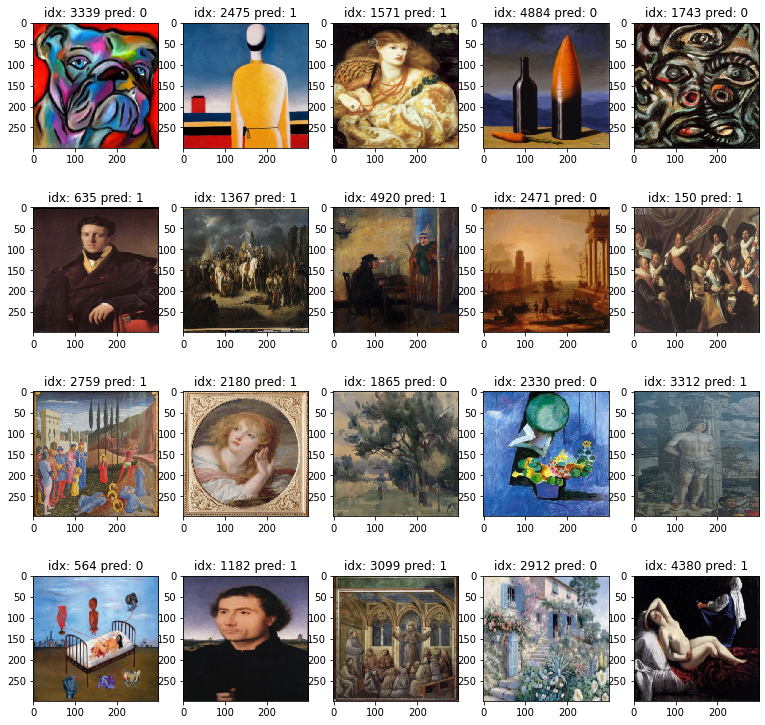

In [ ]:
n = y2_pred.shape[0]
print("Resulting classification: ")
plt.figure(figsize=(13, 13))
for idx in range(0,20):
    i = np.random.randint(0,n)
    plt.subplot(4, 5, idx+1)
    plt.imshow(X2_d[i,:,:],interpolation='nearest')
    title = 'idx: ' + str(i) +' pred: ' + str(int(y2_pred[i]))
    plt.title(title)

In [ ]:
df_submission  = pd.DataFrame({'name':X2, 'person':y2_pred})
df_submission['person'] = df_submission['person'].astype(int)
df_submission.to_csv('df_submission_inception.csv', sep=',', index = False)